# Deep learning examples

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/202-NN_examples.ipynb)

This notebooks contains examples with neural network models.

**Table of contents**

* [Loading dataset](#chapter1)  
* [Architecture](#chapter2)
* [Testing models](#chapter3)
    * [Baseline](#section_3_1)
    * [DeepAR](#section_3_2)
    * [DeepARNative](#section_3_3)
    * [TFT](#section_3_4)
    * [TFTNative](#section_3_5)
    * [RNN](#section_3_6)
    * [MLP](#section_3_7)
    * [Deep State Model](#section_3_8)
    * [N-BEATS Model](#section_3_9)
    * [PatchTS Model](#section_3_10)

In [1]:
!pip install "etna[torch]" -q

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import random

import numpy as np
import pandas as pd
import torch

from etna.analysis import plot_backtest
from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAE
from etna.metrics import MAPE
from etna.metrics import SMAPE
from etna.models import SeasonalMovingAverageModel
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import LabelEncoderTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.transforms import SegmentEncoderTransform
from etna.transforms import StandardScalerTransform

wandb: WARNING Disabling SSL verification.  Connections to this server are not verified and may be insecure!


In [4]:
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## 1. Loading dataset <a class="anchor" id="chapter1"></a>

We are going to take some toy dataset. Let's load and look at it.

In [5]:
df = pd.read_csv("data/example_dataset.csv")
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


Our library works with the special data structure `TSDataset`. Let's create it as it was done in "Get started" notebook.

In [6]:
ts = TSDataset(df, freq="D")
ts.head(5)

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


## 2. Architecture <a class="anchor" id="chapter2"></a>

Our library has two types of models:

- Models from [PyTorch Forecasting](https://github.com/jdb78/pytorch-forecasting)
- Native models.

First, let's describe the `pytorch-forecasting` models, because they require a special handling. There are two ways to use these models: default one and via using `PytorchForecastingDatasetBuilder` for using extra features. 

To include extra features we use `PytorchForecastingDatasetBuilder` class.

Let's look at it closer.

In [7]:
from etna.models.nn.utils import PytorchForecastingDatasetBuilder

In [8]:
?PytorchForecastingDatasetBuilder

We can see a pretty scary signature, but don't panic, we will look at the most important parameters. 

* `time_varying_known_reals` &mdash; known real values that change across the time (real regressors), now it it necessary to add "time_idx" variable to the list;
* `time_varying_unknown_reals` &mdash; our real value target, set it to `["target"]`;
* `max_prediction_length` &mdash; our horizon for forecasting;
* `max_encoder_length` &mdash; length of past context to use;
* `static_categoricals` &mdash; static categorical values, for example, if we use multiple segments it can be some its characteristics including identifier: "segment";
* `time_varying_known_categoricals` &mdash; known categorical values that change across the time (categorical regressors);
* `target_normalizer` &mdash; class for normalization targets across different segments.

Our library currently supports these `pytorch-forecasting` models:

* [DeepAR](https://arxiv.org/abs/1704.04110) (will be removed in version 3.0),
* [TFT](https://arxiv.org/abs/1912.09363) (will be removed in version 3.0).

As for the native neural network models, they are simpler to use, because they don't require `PytorchForecastingTransform`. We will see how to use them on examples.

## 3. Testing models <a class="anchor" id="chapter3"></a>

In this section we will test our models on example.

In [9]:
HORIZON = 7
metrics = [SMAPE(), MAPE(), MAE()]

### 3.1 Baseline <a class="anchor" id="section_3_1"></a>

For comparison let's train some simple model as a baseline.

In [10]:
model_sma = SeasonalMovingAverageModel(window=5, seasonality=7)
linear_trend_transform = LinearTrendTransform(in_column="target")

pipeline_sma = Pipeline(model=model_sma, horizon=HORIZON, transforms=[linear_trend_transform])

In [11]:
metrics_sma, forecast_sma, fold_info_sma = pipeline_sma.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


In [12]:
metrics_sma

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,6.343943,6.124296,33.196532,0
0,segment_a,5.346946,5.192455,27.938101,1
0,segment_a,7.510347,7.189999,40.028565,2
1,segment_b,7.178822,6.920176,17.818102,0
1,segment_b,5.672504,5.554555,13.719200,1
1,segment_b,3.327846,3.359712,7.680919,2
2,segment_c,6.430429,6.200580,10.877718,0
2,segment_c,5.947090,5.727531,10.701336,1
2,segment_c,6.186545,5.943679,11.359563,2
3,segment_d,4.707899,4.644170,39.918646,0


In [13]:
score = metrics_sma["SMAPE"].mean()
print(f"Average SMAPE for Seasonal MA: {score:.3f}")

Average SMAPE for Seasonal MA: 5.547


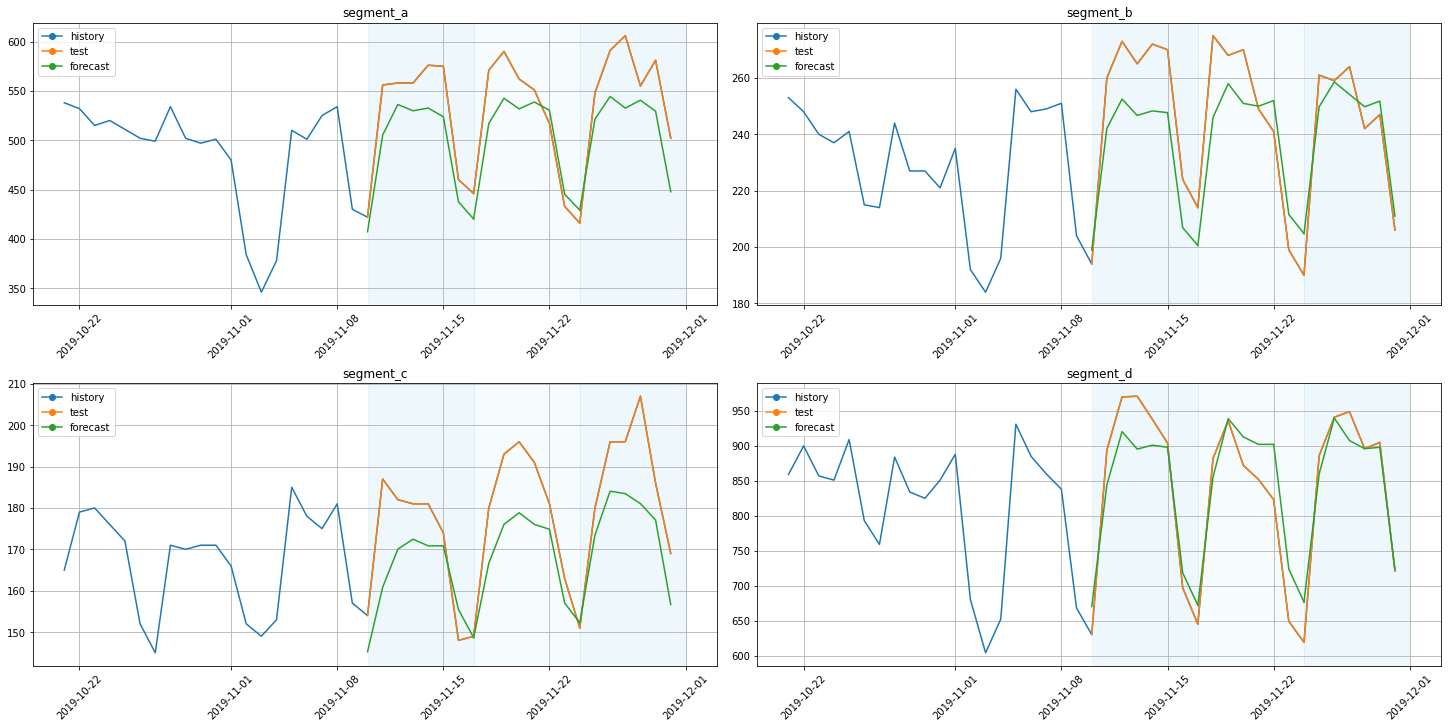

In [14]:
plot_backtest(forecast_sma, ts, history_len=20)

### 3.2 DeepAR <a class="anchor" id="section_3_2"></a>

In [15]:
from etna.models.nn import DeepARModel

Before training let's fix seeds for reproducibility.

In [16]:
set_seed()

#### Default way

In [17]:
model_deepar = DeepARModel(
    encoder_length=HORIZON,
    decoder_length=HORIZON,
    trainer_params=dict(max_epochs=150, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)
metrics = [SMAPE(), MAPE(), MAE()]

pipeline_deepar = Pipeline(model=model_deepar, horizon=HORIZON)

In [18]:
metrics_deepar, forecast_deepar, fold_info_deepar = pipeline_deepar.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  2.2min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  4.5min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  6.9min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  6.9min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


In [19]:
metrics_deepar

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,11.457985,10.746764,58.296596,0
0,segment_a,3.176019,3.188004,16.515852,1
0,segment_a,7.292166,7.075430,38.055638,2
1,segment_b,8.014023,7.647102,20.117395,0
1,segment_b,4.404579,4.387297,10.633220,1
1,segment_b,5.720607,6.126162,13.026145,2
2,segment_c,6.136967,6.092227,10.315159,0
2,segment_c,4.311422,4.218119,7.638395,1
2,segment_c,9.405841,9.125036,16.484007,2
3,segment_d,5.807082,5.653967,50.962088,0


To summarize it we will take mean value of SMAPE metric because it is scale tolerant.

In [20]:
score = metrics_deepar["SMAPE"].mean()
print(f"Average SMAPE for DeepAR: {score:.3f}")

Average SMAPE for DeepAR: 6.184


#### Dataset Builder: creating dataset for DeepAR with etxtra features.

In [21]:
from pytorch_forecasting.data import GroupNormalizer

set_seed()

transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
num_lags = 10
transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)
lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]

dataset_builder_deepar = PytorchForecastingDatasetBuilder(
    max_encoder_length=HORIZON,
    max_prediction_length=HORIZON,
    time_varying_known_reals=["time_idx"] + lag_columns,
    time_varying_unknown_reals=["target"],
    time_varying_known_categoricals=["dateflag_day_number_in_week"],
    target_normalizer=GroupNormalizer(groups=["segment"]),
)

Now we are going to start backtest.

In [22]:
model_deepar = DeepARModel(
    dataset_builder=dataset_builder_deepar,
    trainer_params=dict(max_epochs=150, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)

pipeline_deepar = Pipeline(
    model=model_deepar,
    horizon=HORIZON,
    transforms=[transform_lag, transform_date],
)

In [23]:
metrics_deepar, forecast_deepar, fold_info_deepar = pipeline_deepar.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  2.3min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  4.6min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  7.0min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  7.0min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


Let's compare results across different segments.

In [24]:
metrics_deepar

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,7.796825,7.472601,39.812116,0
0,segment_a,3.667108,3.613067,18.643385,1
0,segment_a,4.231661,4.138719,22.416286,2
1,segment_b,6.644786,6.406091,16.496137,0
1,segment_b,3.708771,3.632007,9.208387,1
1,segment_b,3.485869,3.512980,8.107008,2
2,segment_c,4.850796,4.707044,8.339118,0
2,segment_c,5.969359,5.779788,10.466917,1
2,segment_c,5.508545,5.325093,10.010921,2
3,segment_d,4.996653,4.876972,42.090489,0


To summarize it we will take mean value of SMAPE metric because it is scale tolerant.

In [25]:
score = metrics_deepar["SMAPE"].mean()
print(f"Average SMAPE for DeepAR: {score:.3f}")

Average SMAPE for DeepAR: 4.835


Visualize results.

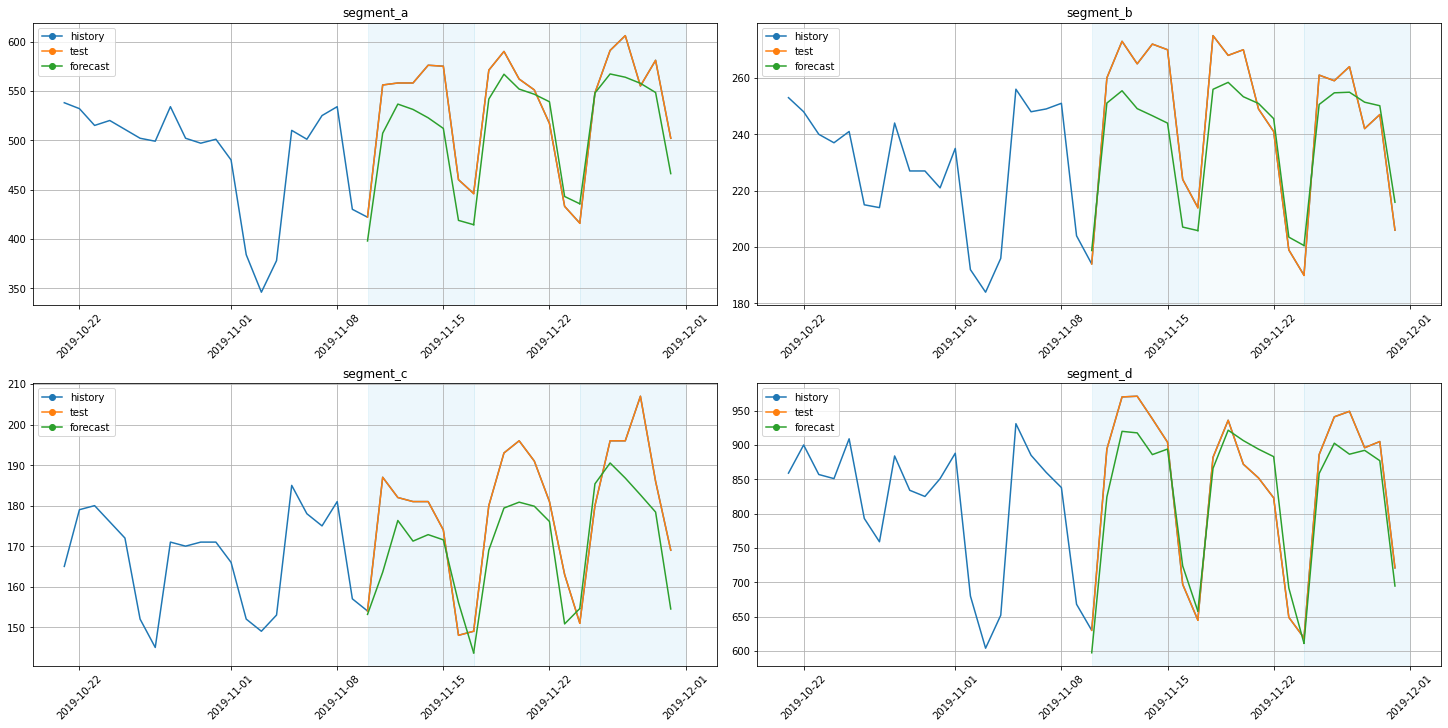

In [26]:
plot_backtest(forecast_deepar, ts, history_len=20)

### 3.3 DeepARNative <a class="anchor" id="section_3_3"></a>

It is recommended to use our native implementation of DeepAR, we will remove Pytorch Forecasting version in etna 3.0.0.

In [27]:
from etna.models.nn import DeepARNativeModel

In [28]:
scaler = StandardScalerTransform(in_column="target")
transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
segment_encoder = SegmentEncoderTransform()
label_encoder = LabelEncoderTransform(
    in_column="dateflag_day_number_in_week", strategy="none", out_column="dateflag_day_number_in_week_label"
)

embedding_sizes = {"dateflag_day_number_in_week": (7, 7), "segment_code": (4, 7)}

In [29]:
set_seed()

model_deepar_native = DeepARNativeModel(
    input_size=1,
    encoder_length=2 * HORIZON,
    decoder_length=HORIZON,
    embedding_sizes=embedding_sizes,
    lr=0.01,
    scale=False,
    n_samples=100,
    trainer_params=dict(max_epochs=20),
)

pipeline_deepar_native = Pipeline(
    model=model_deepar_native,
    horizon=HORIZON,
    transforms=[scaler, transform_date, segment_encoder, label_encoder],
)

In [30]:
metrics_deepar_native, forecast_deepar_native, fold_info_deepar_native = pipeline_deepar_native.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params
----------------------------------------------
0 | loss       | GaussianLoss   | 0     
1 | embedding  | MultiEmbedding | 91    
2 | rnn        | LSTM           | 4.3 K 
3 | projection | ModuleDict     | 34    
----------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   29.3s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params
----------------------------------------------
0 | loss       | GaussianLoss   | 0     
1 | embedding  | MultiEmbedding | 91    
2 | rnn        | LSTM           | 4.3 K 
3 | projection | ModuleDict     | 34    
----------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   58.9s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params
----------------------------------------------
0 | loss       | GaussianLoss   | 0     
1 | embedding  | MultiEmbedding | 91    
2 | rnn        | LSTM           | 4.3 K 
3 | projection | ModuleDict     | 34    
----------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


In [31]:
score = metrics_deepar_native["SMAPE"].mean()
print(f"Average SMAPE for DeepARNative: {score:.3f}")

Average SMAPE for DeepARNative: 6.541


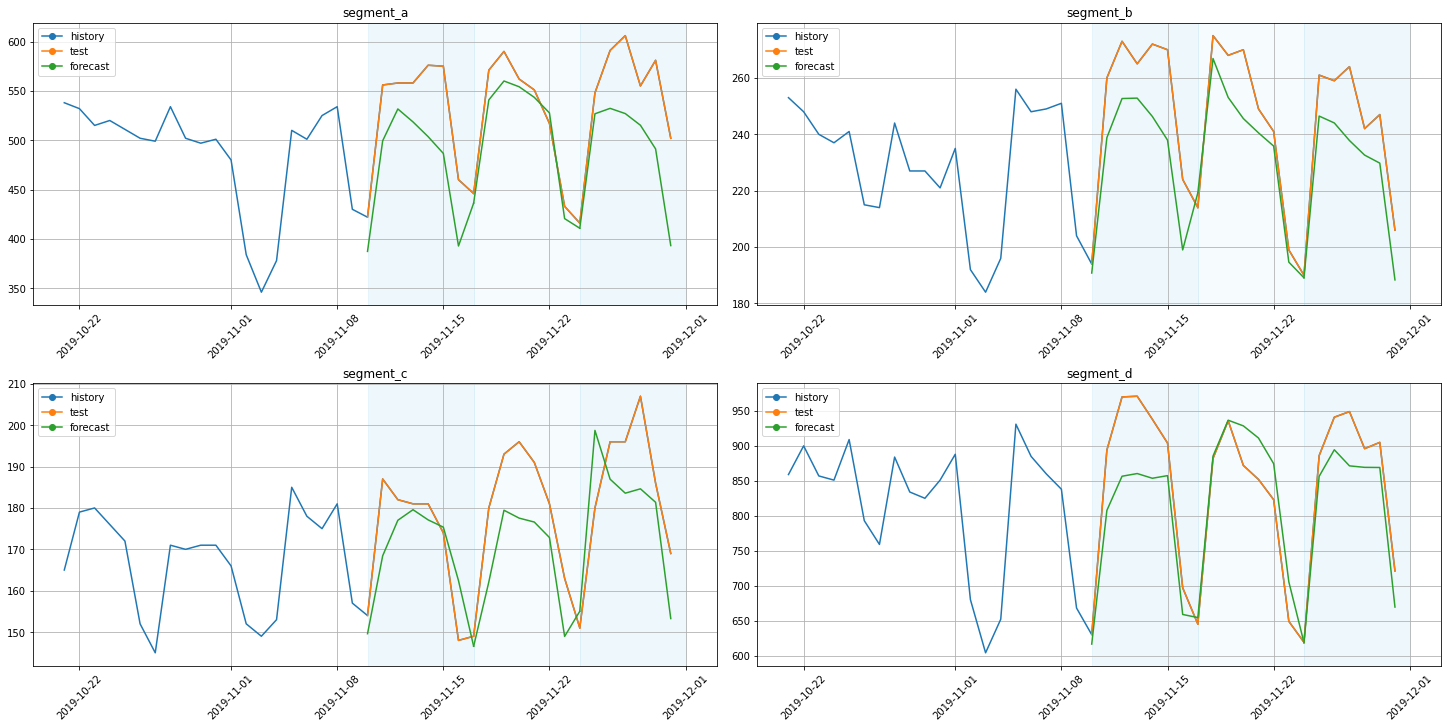

In [32]:
plot_backtest(forecast_deepar_native, ts, history_len=20)

### 3.4 TFT <a class="anchor" id="section_3_4"></a>

Let's move to the next model.

In [33]:
from etna.models.nn import TFTModel

In [34]:
set_seed()

#### Default way

In [35]:
model_tft = TFTModel(
    encoder_length=HORIZON,
    decoder_length=HORIZON,
    trainer_params=dict(max_epochs=200, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)

pipeline_tft = Pipeline(
    model=model_tft,
    horizon=HORIZON,
)

In [36]:
metrics_tft, forecast_tft, fold_info_tft = pipeline_tft.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_cont

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  4.6min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
6  | decoder_variable_selection         | VariableSelectionNetwork      

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  9.4min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
6  | decoder_variable_selection         | VariableSelectionNetwork      

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 14.3min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 14.3min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


In [37]:
metrics_tft

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,40.672898,33.431255,181.536342,0
0,segment_a,9.250597,9.923689,47.444972,1
0,segment_a,9.813989,9.510262,51.294577,2
1,segment_b,32.807489,40.479604,96.606441,0
1,segment_b,29.624659,25.356150,64.590735,1
1,segment_b,7.350867,7.605594,16.847937,2
2,segment_c,67.610710,103.117201,175.320701,0
2,segment_c,7.182262,7.453978,12.599984,1
2,segment_c,9.692566,9.306065,17.481020,2
3,segment_d,83.180637,58.408386,509.964892,0


In [38]:
score = metrics_tft["SMAPE"].mean()
print(f"Average SMAPE for TFT: {score:.3f}")

Average SMAPE for TFT: 29.769


#### Dataset Builder

In [39]:
set_seed()

transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
num_lags = 10
transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)
lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]

dataset_builder_tft = PytorchForecastingDatasetBuilder(
    max_encoder_length=HORIZON,
    max_prediction_length=HORIZON,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["target"],
    time_varying_known_categoricals=["dateflag_day_number_in_week"],
    static_categoricals=["segment"],
    target_normalizer=GroupNormalizer(groups=["segment"]),
)

In [40]:
model_tft = TFTModel(
    dataset_builder=dataset_builder_tft,
    trainer_params=dict(max_epochs=200, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)

pipeline_tft = Pipeline(
    model=model_tft,
    horizon=HORIZON,
    transforms=[transform_lag, transform_date],
)

In [41]:
metrics_tft, forecast_tft, fold_info_tft = pipeline_tft.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 47    
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_cont

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  4.9min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 47    
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork      

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed: 10.2min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 47    
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork      

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 15.4min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 15.4min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


In [42]:
metrics_tft

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,4.954594,4.861804,25.372825,0
0,segment_a,7.754915,7.631246,39.995815,1
0,segment_a,4.072187,3.931299,22.857274,2
1,segment_b,5.653733,5.452502,14.249708,0
1,segment_b,5.565292,5.428447,13.956488,1
1,segment_b,3.886476,3.999029,9.210266,2
2,segment_c,3.815528,3.743413,6.616340,0
2,segment_c,4.531915,4.425449,8.114482,1
2,segment_c,7.780429,7.491119,14.045940,2
3,segment_d,8.103217,7.994725,68.973964,0


In [43]:
score = metrics_tft["SMAPE"].mean()
print(f"Average SMAPE for TFT: {score:.3f}")

Average SMAPE for TFT: 5.460


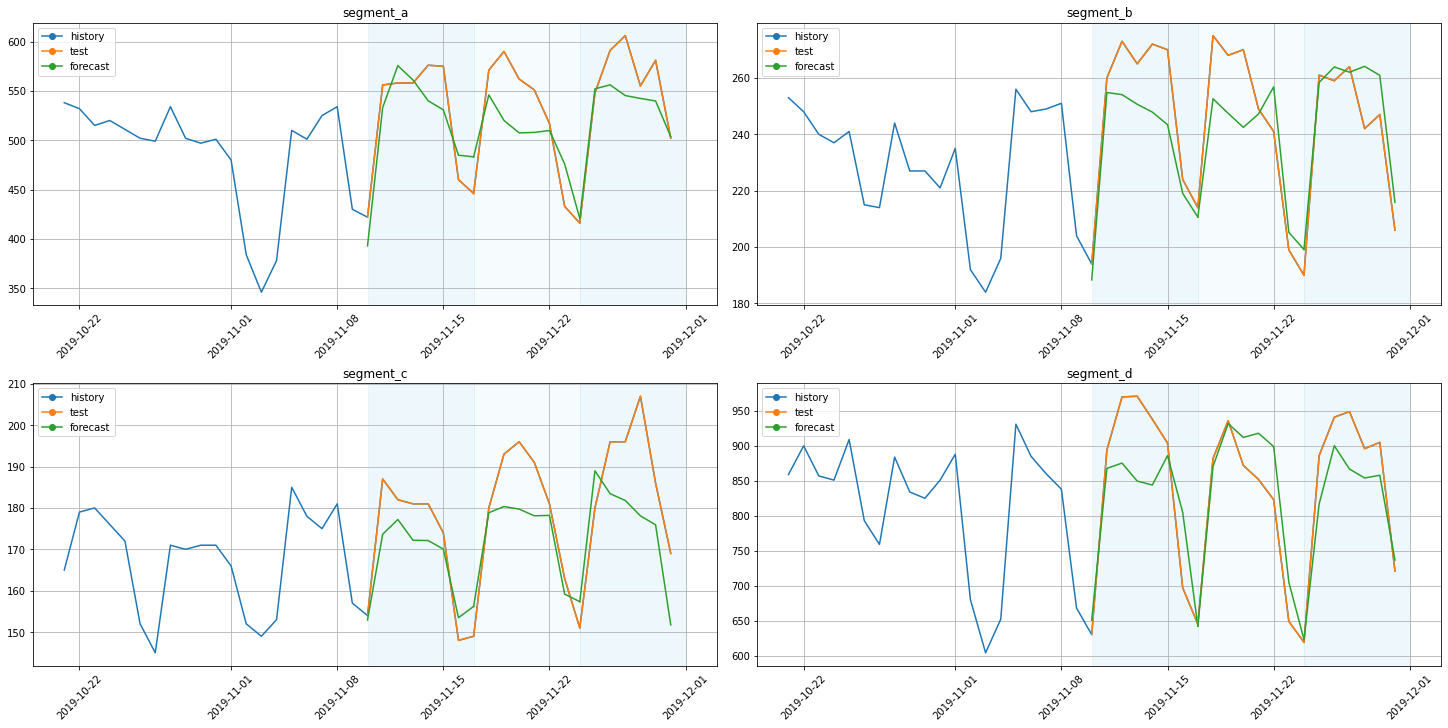

In [44]:
plot_backtest(forecast_tft, ts, history_len=20)

### 3.5 TFTNative <a class="anchor" id="section_3_5"></a>

It is recommended to use our native implementation of TFT, we will remove Pytorch Forecasting version in etna 3.0.0.

In [45]:
from etna.models.nn import TFTNativeModel

In [46]:
num_lags = 6
lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]
transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)

transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")

std = StandardScalerTransform(in_column=["target"])

encoder = SegmentEncoderTransform()
label_encoder = LabelEncoderTransform(
    in_column="dateflag_day_number_in_week", strategy="none", out_column="dateflag_day_number_in_week_label"
)

In [47]:
set_seed()

model_tft_native = TFTNativeModel(
    encoder_length=HORIZON,
    decoder_length=HORIZON,
    static_categoricals=["segment_code"],
    time_varying_categoricals_encoder=["dateflag_day_number_in_week_label"],
    time_varying_categoricals_decoder=["dateflag_day_number_in_week_label"],
    time_varying_reals_encoder=["target"] + lag_columns,
    time_varying_reals_decoder=lag_columns,
    num_embeddings={"segment_code": len(ts.segments), "dateflag_day_number_in_week_label": 7},
    n_heads=4,
    num_layers=2,
    hidden_size=64,
    lr=0.0001,
    train_batch_size=64,
    trainer_params=dict(max_epochs=15, gradient_clip_val=0.1),
)
pipeline_tft_native = Pipeline(
    model=model_tft_native, horizon=HORIZON, transforms=[std, transform_lag, transform_date, encoder, label_encoder]
)

In [48]:
metrics_tft_native, forecast_tft_native, fold_info_tft_native = pipeline_tft_native.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                            | Type                     | Params
------------------------------------------------------------------------------
0  | loss                            | MSELoss                  | 0     
1  | static_scalers                  | ModuleDict               | 0     
2  | static_embeddings               | ModuleDict               | 320   
3  | time_varying_scalers_encoder    | ModuleDict               | 896   
4  | time_varying_embeddings_encoder | ModuleDict               | 512   
5  | time_varying_scalers_decoder    | ModuleDict               | 768   
6  | time_varying_embeddings_decoder | ModuleDict               | 512   
7  | static_variable_selection       | VariableSelectionNetwork | 25.3 K
8  | encoder_variable_selection      | VariableSelectionNetwork | 704 K 
9  | decoder_variable_selection      | Vari

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   38.1s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                            | Type                     | Params
------------------------------------------------------------------------------
0  | loss                            | MSELoss                  | 0     
1  | static_scalers                  | ModuleDict               | 0     
2  | static_embeddings               | ModuleDict               | 320   
3  | time_varying_scalers_encoder    | ModuleDict               | 896   
4  | time_varying_embeddings_encoder | ModuleDict               | 512   
5  | time_varying_scalers_decoder    | ModuleDict               | 768   
6  | time_varying_embeddings_decoder | ModuleDict               | 512   
7  | static_variable_selection       | VariableSelectionNetwork | 25.3 K
8  | en

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  1.3min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                            | Type                     | Params
------------------------------------------------------------------------------
0  | loss                            | MSELoss                  | 0     
1  | static_scalers                  | ModuleDict               | 0     
2  | static_embeddings               | ModuleDict               | 320   
3  | time_varying_scalers_encoder    | ModuleDict               | 896   
4  | time_varying_embeddings_encoder | ModuleDict               | 512   
5  | time_varying_scalers_decoder    | ModuleDict               | 768   
6  | time_varying_embeddings_decoder | ModuleDict               | 512   
7  | static_variable_selection       | VariableSelectionNetwork | 25.3 K
8  | en

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


In [49]:
score = metrics_tft_native["SMAPE"].mean()
print(f"Average SMAPE for TFTNative: {score:.3f}")

Average SMAPE for TFTNative: 6.420


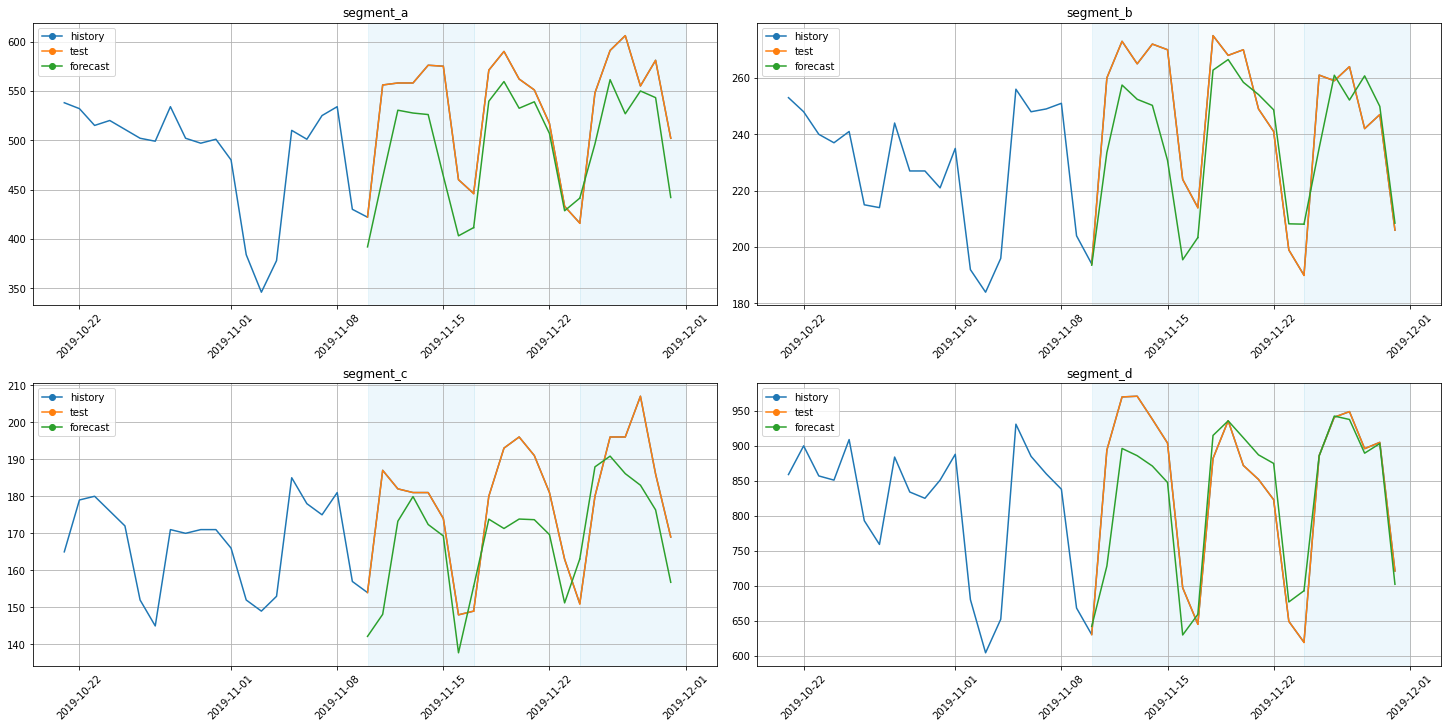

In [50]:
plot_backtest(forecast_tft_native, ts, history_len=20)

### 3.6 RNN <a class="anchor" id="section_3_6"></a>

We'll use RNN model based on LSTM cell

In [51]:
from etna.models.nn import RNNModel

In [52]:
num_lags = 10
scaler = StandardScalerTransform(in_column="target")
transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)
transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
segment_encoder = SegmentEncoderTransform()
label_encoder = LabelEncoderTransform(
    in_column="dateflag_day_number_in_week", strategy="none", out_column="dateflag_day_number_in_week_label"
)

embedding_sizes = {"dateflag_day_number_in_week": (7, 7), "segment_code": (4, 7)}

In [53]:
set_seed()

model_rnn = RNNModel(
    input_size=11,
    encoder_length=2 * HORIZON,
    decoder_length=HORIZON,
    embedding_sizes=embedding_sizes,
    trainer_params=dict(max_epochs=5),
    lr=1e-3,
)

pipeline_rnn = Pipeline(
    model=model_rnn,
    horizon=HORIZON,
    transforms=[scaler, transform_lag, transform_date, segment_encoder, label_encoder],
)

In [54]:
metrics_rnn, forecast_rnn, fold_info_rnn = pipeline_rnn.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params
----------------------------------------------
0 | loss       | MSELoss        | 0     
1 | embedding  | MultiEmbedding | 91    
2 | rnn        | LSTM           | 4.9 K 
3 | projection | Linear         | 17    
----------------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    6.9s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params
----------------------------------------------
0 | loss       | MSELoss        | 0     
1 | embedding  | MultiEmbedding | 91    
2 | rnn        | LSTM           | 4.9 K 
3 | projection | Linear         | 17    
----------------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   13.8s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params
----------------------------------------------
0 | loss       | MSELoss        | 0     
1 | embedding  | MultiEmbedding | 91    
2 | rnn        | LSTM           | 4.9 K 
3 | projection | Linear         | 17    
----------------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   21.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   21.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


In [55]:
score = metrics_rnn["SMAPE"].mean()
print(f"Average SMAPE for LSTM: {score:.3f}")

Average SMAPE for LSTM: 5.836


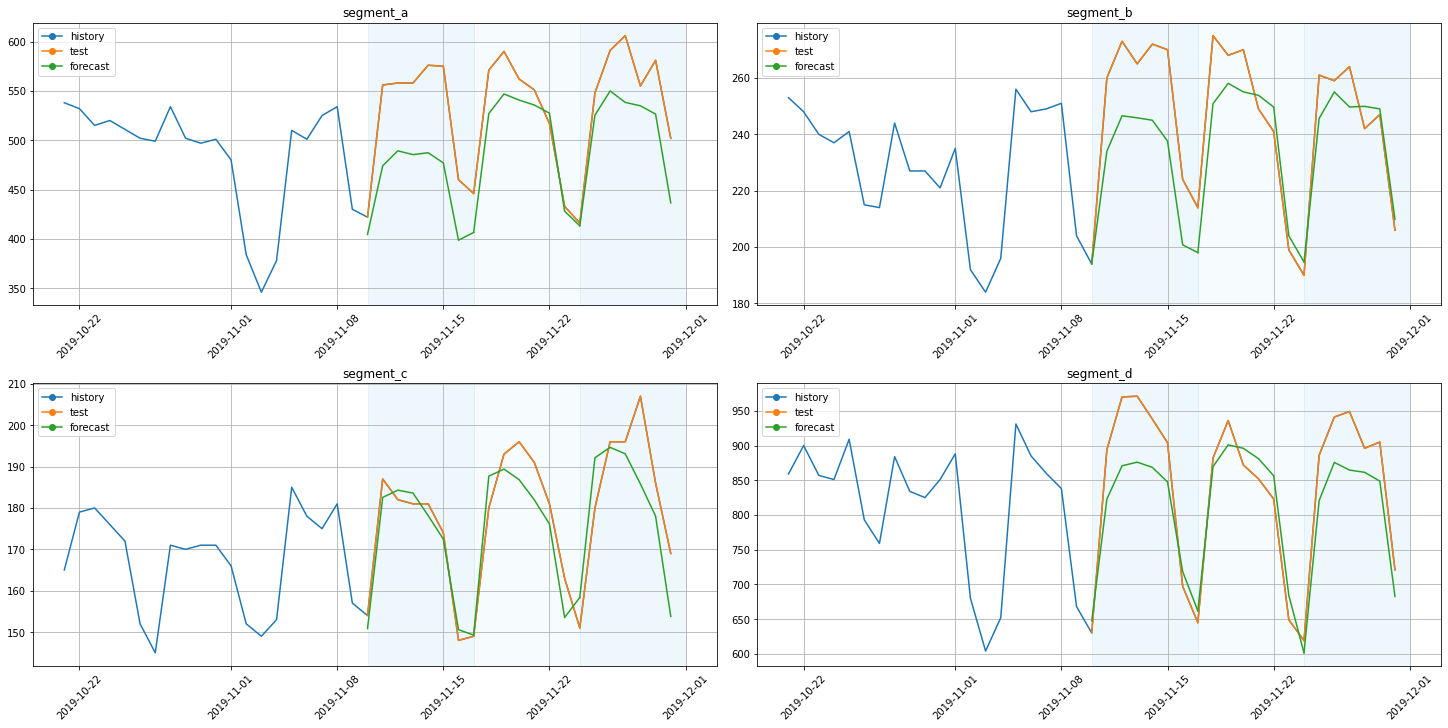

In [56]:
plot_backtest(forecast_rnn, ts, history_len=20)

### 3.7 MLP <a class="anchor" id="section_3_7"></a>

Base model with linear layers and activations.

In [57]:
from etna.models.nn import MLPModel

In [58]:
num_lags = 14
transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)
transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
segment_encoder = SegmentEncoderTransform()
label_encoder = LabelEncoderTransform(
    in_column="dateflag_day_number_in_week", strategy="none", out_column="dateflag_day_number_in_week_label"
)
lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]
embedding_sizes = {"dateflag_day_number_in_week": (7, 7), "segment_code": (4, 7), "dateflag_is_weekend": (2, 5)}

In [59]:
set_seed()

model_mlp = MLPModel(
    input_size=14,
    hidden_size=[16],
    embedding_sizes=embedding_sizes,
    decoder_length=HORIZON,
    trainer_params=dict(max_epochs=50, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)
metrics = [SMAPE(), MAPE(), MAE()]

pipeline_mlp = Pipeline(
    model=model_mlp, transforms=[transform_lag, transform_date, segment_encoder, label_encoder], horizon=HORIZON
)

In [60]:
metrics_mlp, forecast_mlp, fold_info_mlp = pipeline_mlp.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params
---------------------------------------------
0 | loss      | MSELoss        | 0     
1 | embedding | MultiEmbedding | 106   
2 | mlp       | Sequential     | 561   
---------------------------------------------
667       Trainable params
0         Non-trainable params
667       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.6s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params
---------------------------------------------
0 | loss      | MSELoss        | 0     
1 | embedding | MultiEmbedding | 106   
2 | mlp       | Sequential     | 561   
---------------------------------------------
667       Trainable params
0         Non-trainable params
667       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    5.4s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params
---------------------------------------------
0 | loss      | MSELoss        | 0     
1 | embedding | MultiEmbedding | 106   
2 | mlp       | Sequential     | 561   
---------------------------------------------
667       Trainable params
0         Non-trainable params
667       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    8.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    8.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


In [61]:
score = metrics_mlp["SMAPE"].mean()
print(f"Average SMAPE for MLP: {score:.3f}")

Average SMAPE for MLP: 6.141


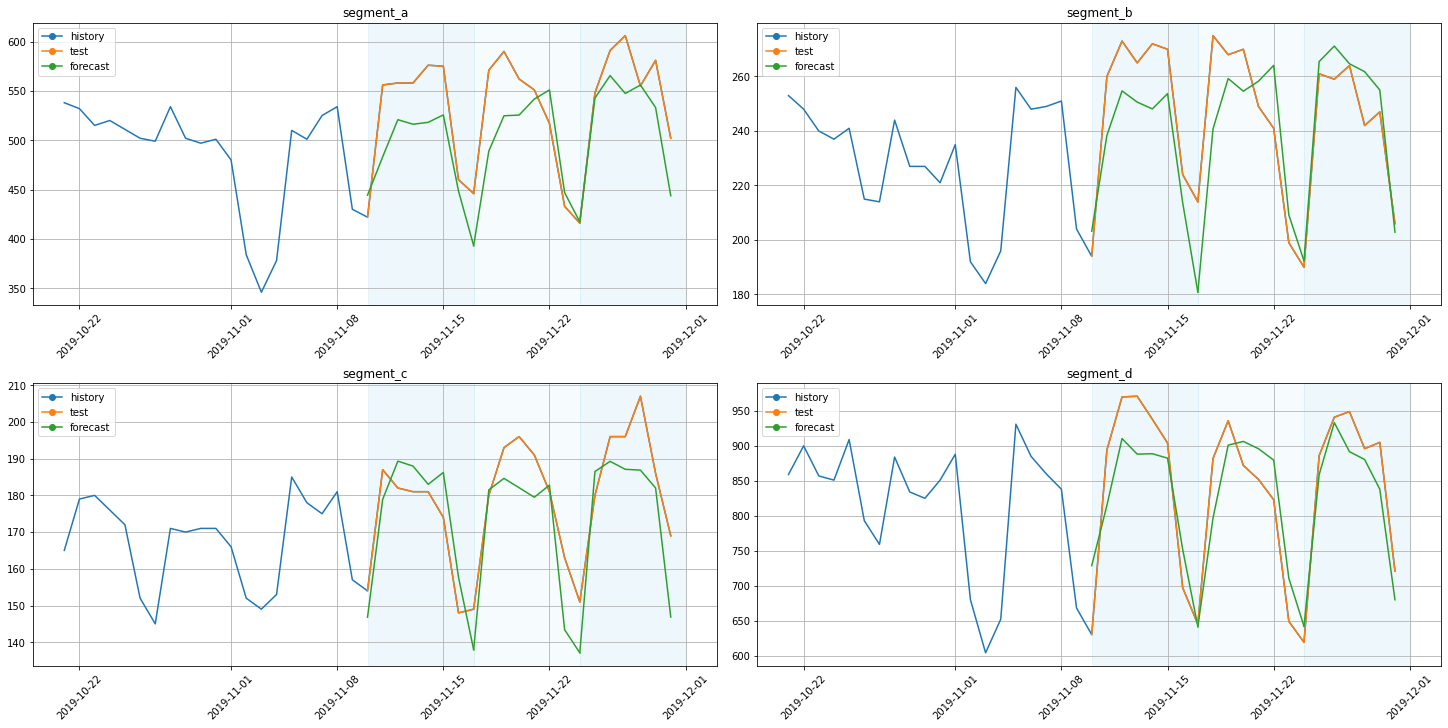

In [62]:
plot_backtest(forecast_mlp, ts, history_len=20)

### 3.8 Deep State Model <a class="anchor" id="section_3_8"></a>

`Deep State Model` works well with multiple similar time-series. It inffers shared patterns from them.

We have to determine the type of seasonality in data (based on data granularity), `SeasonalitySSM` class is responsible for this. In this example, we have daily data, so we use day-of-week (7 seasons) and day-of-month (31 seasons) models. We also set the trend component using the `LevelTrendSSM` class. Also in the model we use time-based features like day-of-week, day-of-month and time independent feature representing the segment of time series.

In [63]:
from etna.models.nn import DeepStateModel
from etna.models.nn.deepstate import CompositeSSM
from etna.models.nn.deepstate import LevelTrendSSM
from etna.models.nn.deepstate import SeasonalitySSM

In [64]:
num_lags = 7
transforms = [
    SegmentEncoderTransform(),
    StandardScalerTransform(in_column="target"),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        week_number_in_month=False,
        week_number_in_year=False,
        month_number_in_year=False,
        year_number=False,
        is_weekend=False,
        out_column="dateflag",
    ),
    LagTransform(
        in_column="target",
        lags=[HORIZON + i for i in range(num_lags)],
        out_column="target_lag",
    ),
]


embedding_sizes = {
    "dateflag_day_number_in_week": (7, 7),
    "dateflag_day_number_in_month": (31, 7),
    "segment_code": (4, 7),
}

In [65]:
monthly_smm = SeasonalitySSM(num_seasons=31, timestamp_transform=lambda x: x.day - 1)
weekly_smm = SeasonalitySSM(num_seasons=7, timestamp_transform=lambda x: x.weekday())

In [66]:
set_seed()

model_dsm = DeepStateModel(
    ssm=CompositeSSM(seasonal_ssms=[weekly_smm, monthly_smm], nonseasonal_ssm=LevelTrendSSM()),
    decoder_length=HORIZON,
    encoder_length=2 * HORIZON,
    embedding_sizes=embedding_sizes,
    input_size=7,
    trainer_params=dict(max_epochs=5),
    lr=1e-3,
)

pipeline_dsm = Pipeline(
    model=model_dsm,
    horizon=HORIZON,
    transforms=transforms,
)

In [67]:
metrics_dsm, forecast_dsm, fold_info_dsm = pipeline_dsm.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params
----------------------------------------------
0 | embedding  | MultiEmbedding | 315   
1 | RNN        | LSTM           | 11.2 K
2 | projectors | ModuleDict     | 5.0 K 
----------------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   15.7s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params
----------------------------------------------
0 | embedding  | MultiEmbedding | 315   
1 | RNN        | LSTM           | 11.2 K
2 | projectors | ModuleDict     | 5.0 K 
----------------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   31.8s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type           | Params
----------------------------------------------
0 | embedding  | MultiEmbedding | 315   
1 | RNN        | LSTM           | 11.2 K
2 | projectors | ModuleDict     | 5.0 K 
----------------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   48.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   48.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


In [68]:
score = metrics_dsm["SMAPE"].mean()
print(f"Average SMAPE for DeepStateModel: {score:.3f}")

Average SMAPE for DeepStateModel: 5.309


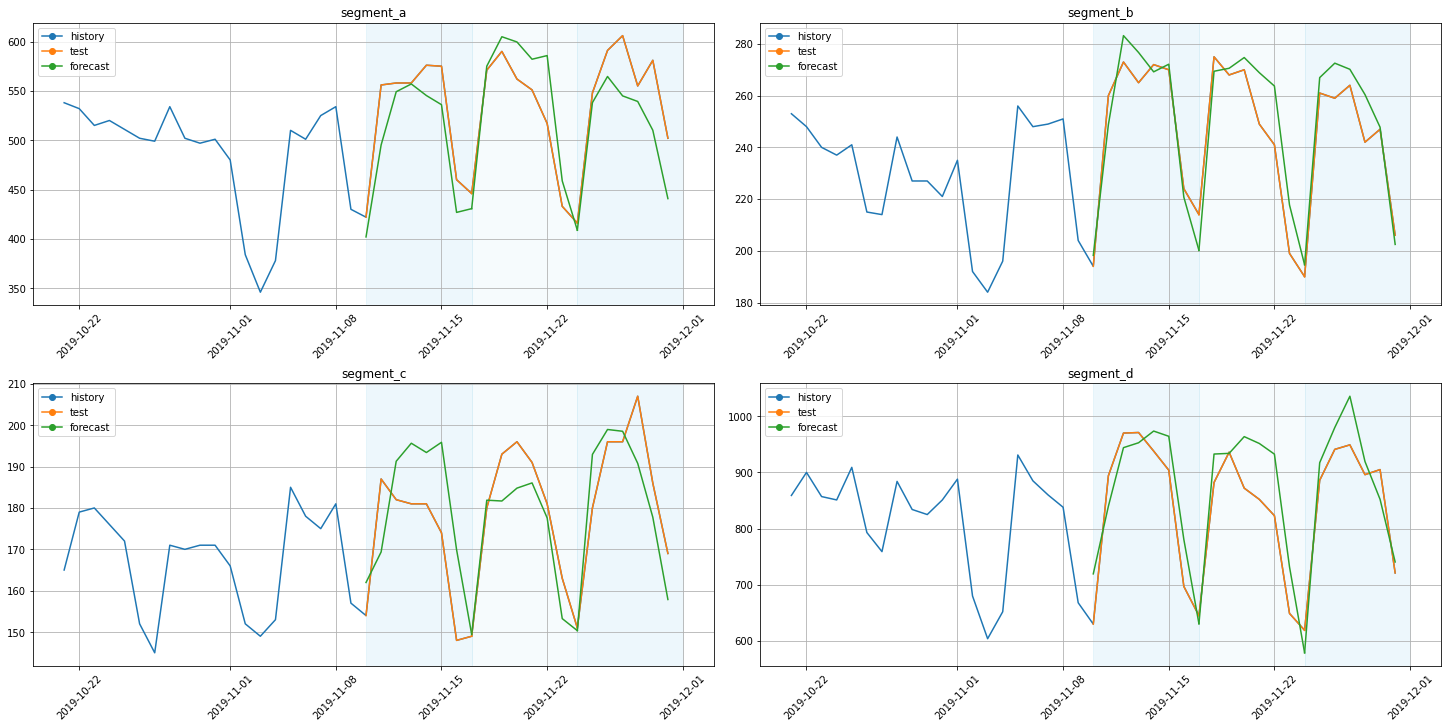

In [69]:
plot_backtest(forecast_dsm, ts, history_len=20)

### 3.9 N-BEATS Model <a class="anchor" id="section_3_9"></a>

This architecture is based on backward and forward residual links and a deep stack of fully connected layers.

There are two types of models in the library. The `NBeatsGenericModel` class implements a generic deep learning model, while the `NBeatsInterpretableModel` is augmented with certain inductive biases to be interpretable (trend and seasonality).

In [70]:
from etna.models.nn import NBeatsGenericModel
from etna.models.nn import NBeatsInterpretableModel

In [71]:
set_seed()

model_nbeats_generic = NBeatsGenericModel(
    input_size=2 * HORIZON,
    output_size=HORIZON,
    loss="smape",
    stacks=30,
    layers=4,
    layer_size=256,
    trainer_params=dict(max_epochs=1000),
    lr=1e-3,
)

pipeline_nbeats_generic = Pipeline(
    model=model_nbeats_generic,
    horizon=HORIZON,
    transforms=[],
)

In [72]:
metrics_nbeats_generic, forecast_nbeats_generic, _ = pipeline_nbeats_generic.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params
--------------------------------------
0 | model | NBeats      | 206 K 
1 | loss  | NBeatsSMAPE | 0     
--------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.826     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.2min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params
--------------------------------------
0 | model | NBeats      | 206 K 
1 | loss  | NBeatsSMAPE | 0     
--------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.826     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  2.4min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params
--------------------------------------
0 | model | NBeats      | 206 K 
1 | loss  | NBeatsSMAPE | 0     
--------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.826     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  3.6min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  3.6min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


In [73]:
score = metrics_nbeats_generic["SMAPE"].mean()
print(f"Average SMAPE for N-BEATS Generic: {score:.3f}")

Average SMAPE for N-BEATS Generic: 5.545


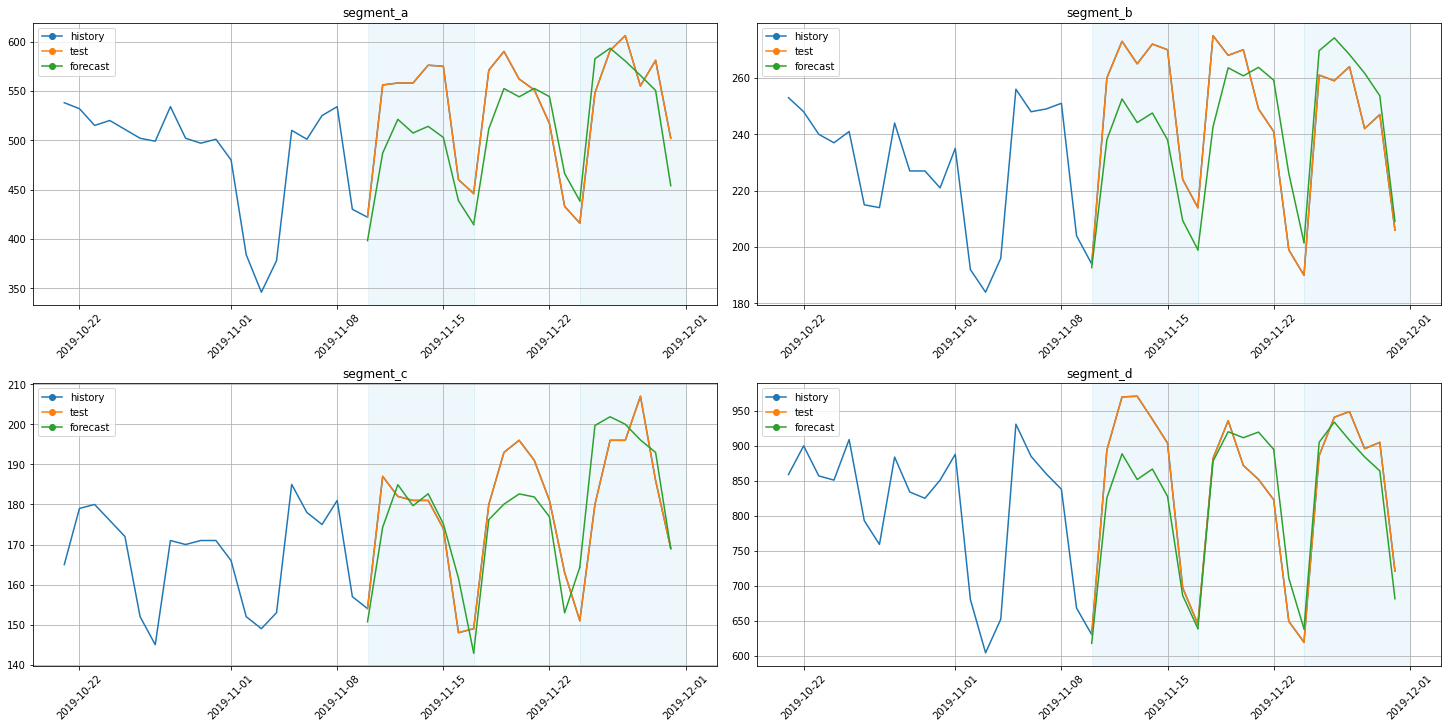

In [74]:
plot_backtest(forecast_nbeats_generic, ts, history_len=20)

In [75]:
model_nbeats_interp = NBeatsInterpretableModel(
    input_size=4 * HORIZON,
    output_size=HORIZON,
    loss="smape",
    trend_layer_size=64,
    seasonality_layer_size=256,
    trainer_params=dict(max_epochs=2000),
    lr=1e-3,
)

pipeline_nbeats_interp = Pipeline(
    model=model_nbeats_interp,
    horizon=HORIZON,
    transforms=[],
)

In [76]:
metrics_nbeats_interp, forecast_nbeats_interp, _ = pipeline_nbeats_interp.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params
--------------------------------------
0 | model | NBeats      | 224 K 
1 | loss  | NBeatsSMAPE | 0     
--------------------------------------
223 K     Trainable params
385       Non-trainable params
224 K     Total params
0.896     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.6min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params
--------------------------------------
0 | model | NBeats      | 224 K 
1 | loss  | NBeatsSMAPE | 0     
--------------------------------------
223 K     Trainable params
385       Non-trainable params
224 K     Total params
0.896     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  3.2min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params
--------------------------------------
0 | model | NBeats      | 224 K 
1 | loss  | NBeatsSMAPE | 0     
--------------------------------------
223 K     Trainable params
385       Non-trainable params
224 K     Total params
0.896     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  4.8min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  4.8min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


In [77]:
score = metrics_nbeats_interp["SMAPE"].mean()
print(f"Average SMAPE for N-BEATS Interpretable: {score:.3f}")

Average SMAPE for N-BEATS Interpretable: 5.512


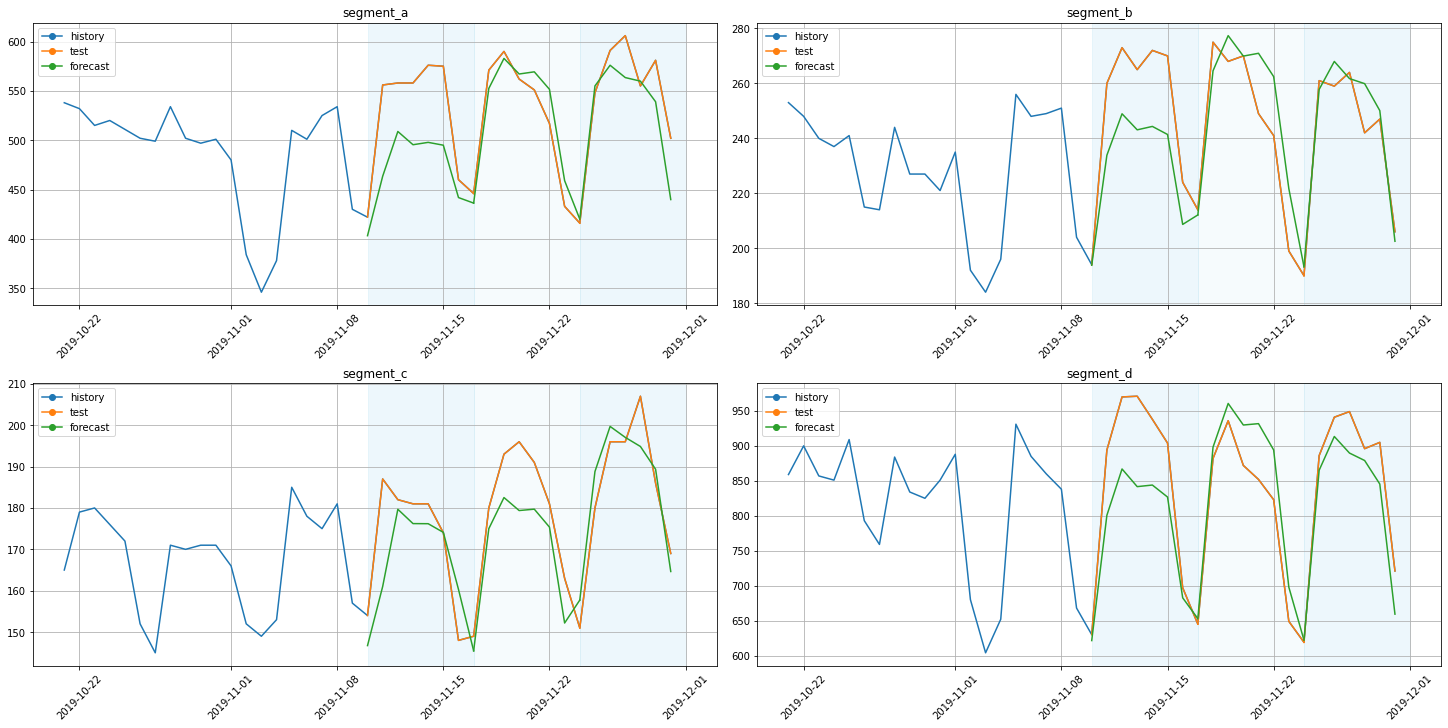

In [78]:
plot_backtest(forecast_nbeats_interp, ts, history_len=20)

### 3.10 PatchTS Model <a class="anchor" id="section_3_10"></a>

Model with transformer encoder that uses patches of timeseries as input words and linear decoder.

In [79]:
from etna.models.nn import PatchTSModel

In [80]:
set_seed()

model_patchts = PatchTSModel(
    decoder_length=HORIZON,
    encoder_length=2 * HORIZON,
    patch_len=1,
    trainer_params=dict(max_epochs=100),
    lr=1e-3,
)

pipeline_patchts = Pipeline(
    model=model_patchts, horizon=HORIZON, transforms=[StandardScalerTransform(in_column="target")]
)

metrics_patchts, forecast_patchts, fold_info_patchs = pipeline_patchts.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | loss       | MSELoss    | 0     
1 | model      | Sequential | 397 K 
2 | projection | Sequential | 1.8 K 
------------------------------------------
399 K     Trainable params
0         Non-trainable params
399 K     Total params
1.598     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  9.0min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | loss       | MSELoss    | 0     
1 | model      | Sequential | 397 K 
2 | projection | Sequential | 1.8 K 
------------------------------------------
399 K     Trainable params
0         Non-trainable params
399 K     Total params
1.598     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed: 18.3min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | loss       | MSELoss    | 0     
1 | model      | Sequential | 397 K 
2 | projection | Sequential | 1.8 K 
------------------------------------------
399 K     Trainable params
0         Non-trainable params
399 K     Total params
1.598     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 27.8min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 27.8min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


In [81]:
score = metrics_patchts["SMAPE"].mean()
print(f"Average SMAPE for PatchTS: {score:.3f}")

Average SMAPE for PatchTS: 5.559


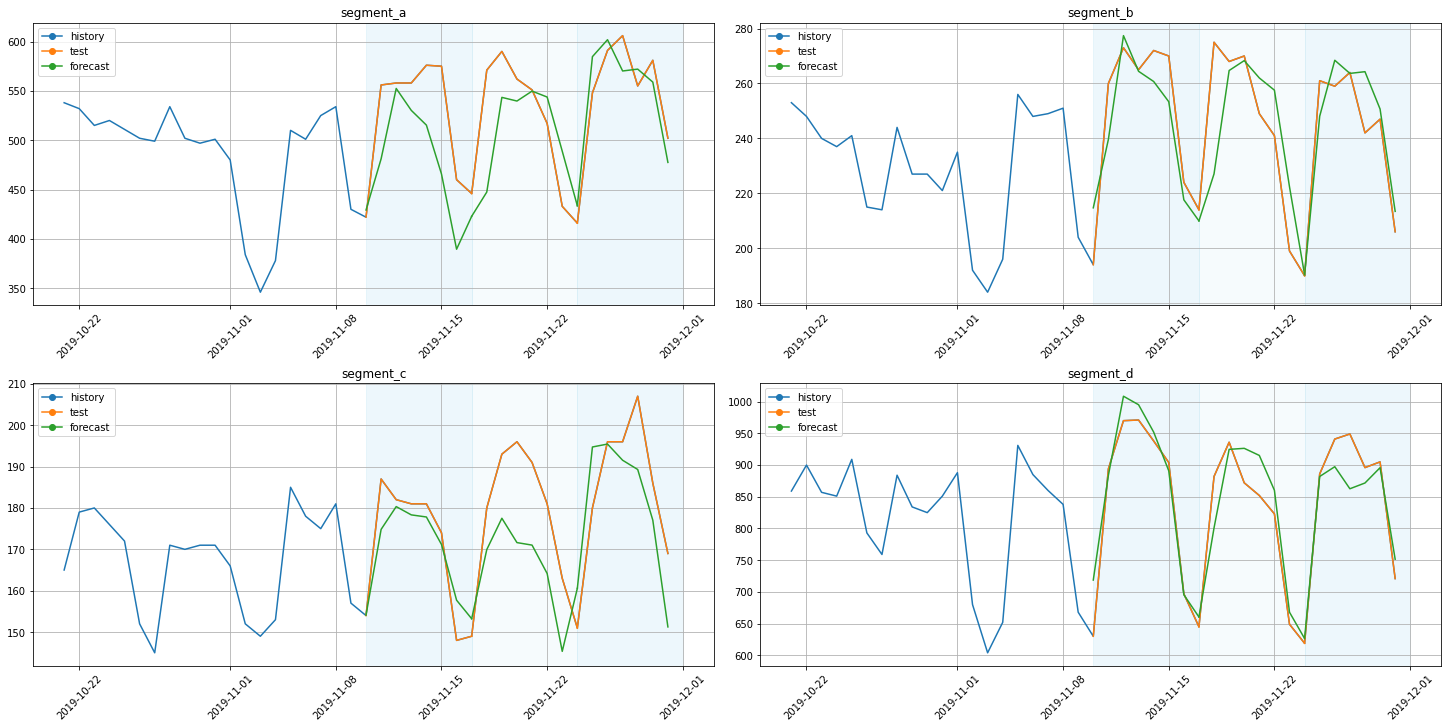

In [82]:
plot_backtest(forecast_patchts, ts, history_len=20)